# 23WS Seminar XAI

The examples presented in the seminar work are available in this notebook.

In [21]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.inspection import permutation_importance

import shap


In [22]:
# load diabetes dataset
diabetes = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(diabetes.data, diabetes.target, random_state=0)


### Linear Regression

[ -43.26198867 -208.66589855  593.40654802  302.89100542 -560.19094014
  261.40753499   -8.86674758  135.93174293  703.18354112   28.34977176]


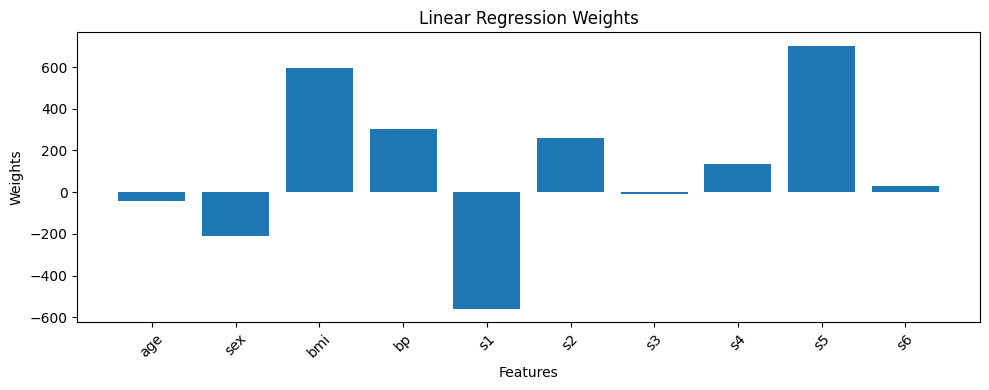

In [23]:
# Create a linear regression model
model_lr = LinearRegression().fit(X_train, y_train)
print(model_lr.coef_)
model_lr.score(X_train, y_train)
model_lr.score(X_test, y_test)

# Get the feature names
feature_names = diabetes.feature_names

# Create a barplot
plt.figure(figsize=(10, 4))
plt.bar(feature_names, model_lr.coef_)
plt.title('Linear Regression Weights')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('./latex/pics/Linear_Regression_Weights.pdf', format='pdf')
plt.show()

In [24]:
print(X_train.shape)
print(X_test.shape)

(331, 10)
(111, 10)


### Lasso

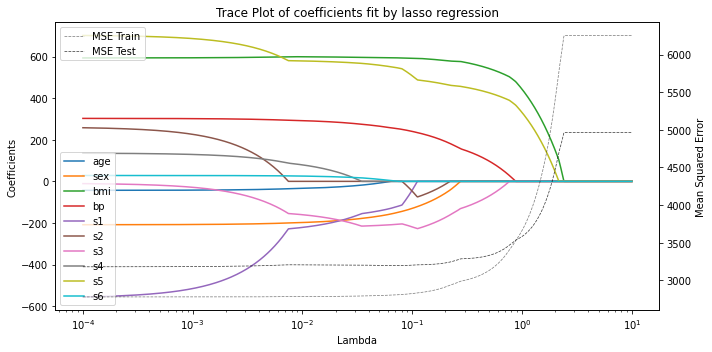

In [25]:
# Set the range of lambda values
lambdas = np.logspace(-4, 1, 1000)
model_lasso_coefs = []
model_lasso_mse_train = []
model_lasso_mse_test = []
model_lasso_r2_train = []
model_lasso_r2_test = []

# Train the model with different regularization strengths
for l in lambdas:
    model_lasso = Lasso()
    model_lasso.set_params(alpha=l)
    model_lasso.fit(X_train, y_train)
    model_lasso_coefs.append(model_lasso.coef_)
    model_lasso_mse_train.append(mean_squared_error(y_train, model_lasso.predict(X_train)))
    model_lasso_mse_test.append(mean_squared_error(y_test, model_lasso.predict(X_test)))
    model_lasso_r2_train.append(model_lasso.score(X_train, y_train))
    model_lasso_r2_test.append(model_lasso.score(X_test, y_test))

# Plot the trace plot with mean squared error and R2 score on the right side of the y-axis
fig, ax1 = plt.subplots(figsize=(10, 5), dpi=72)
ax1.plot(lambdas, model_lasso_coefs)
ax1.set_xscale('log')
ax1.set_xlabel('Lambda')
ax1.set_ylabel('Coefficients')
ax1.set_title('Trace Plot of coefficients fit by lasso regression')
ax1.legend(feature_names, loc='lower left')
ax2 = ax1.twinx()
ax2.plot(lambdas, model_lasso_mse_train, color='black', linestyle='--', label='MSE Train', alpha=0.5, linewidth=0.75)
ax2.plot(lambdas, model_lasso_mse_test, color='black', linestyle='--', label='MSE Test', alpha=0.75, linewidth=0.75)
ax2.set_ylabel('Mean Squared Error')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.savefig('./latex/pics/Trace_Plot_of_Lasso_Fit.pdf', format='pdf')
plt.show()


### Permutation Feature Importance

[0.364291   0.26715981 0.18915788 0.06612442 0.03675235 0.03165284
 0.01271676 0.00139948 0.00071022 0.00061158]
[ 0.29459642  0.1703927   0.20450924  0.09281111  0.07085771  0.05426354
  0.00986454 -0.00327829  0.00231516 -0.0023441 ]


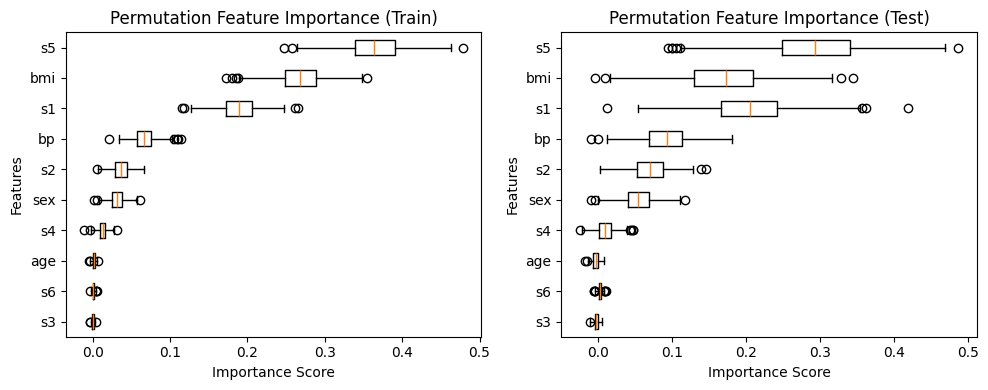

In [26]:

model_pfi = Lasso(alpha=10e-4).fit(X_train, y_train)

# Calculate permutation feature importance for train and test data
result_train = permutation_importance(model_pfi, X_train, y_train, n_repeats=500, random_state=0)
result_test = permutation_importance(model_pfi, X_test, y_test, n_repeats=500, random_state=0)

# Sort the indices of the permutation feature importance scores
importance_scores_mean_train = result_train.importances_mean
sorted_indices = np.argsort(importance_scores_mean_train)[::-1]
importance_scores_mean_train_sorted = result_train.importances_mean[sorted_indices]
importance_scores_mean_test_sorted = result_test.importances_mean[sorted_indices]
print(importance_scores_mean_train_sorted)
print(importance_scores_mean_test_sorted)

# Get importance scores
importance_scores_train_sorted = result_train.importances[sorted_indices]
importance_scores_test_sorted = result_test.importances[sorted_indices]

# Get feature names
feature_names_sorted = np.array(diabetes.feature_names)[sorted_indices]

# Create subplots for train and test data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.boxplot(importance_scores_train_sorted.T[:, ::-1], vert=False, labels=feature_names_sorted[::-1])
ax1.set_title('Permutation Feature Importance (Train)')
ax1.set_xlabel('Importance Score')
ax1.set_ylabel('Features')
ax2.boxplot(importance_scores_test_sorted.T[:, ::-1], vert=False, labels=feature_names_sorted[::-1])
ax2.set_title('Permutation Feature Importance (Test)')
ax2.set_xlabel('Importance Score')
ax2.set_ylabel('Features')

plt.tight_layout()
plt.savefig('./latex/pics/Permutation_Feature_Importance.pdf', format='pdf')
plt.show()


### Shapley Values

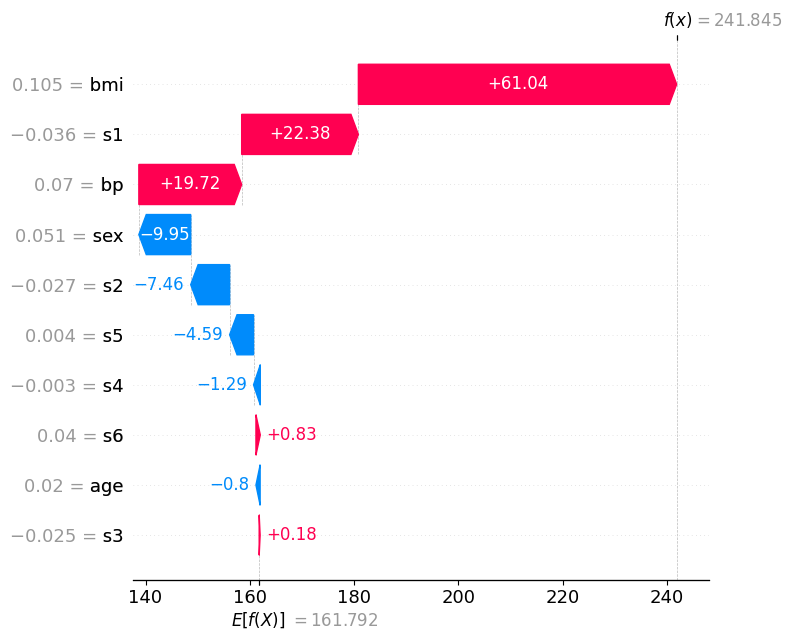

In [27]:
# Create an explainer object for the linear regression model
explainer = shap.Explainer(model_lr, X_train)

# Convert X_test to a dataframe
X_test_df = pd.DataFrame(X_test, columns=feature_names)
# Add feature names to X_test dataframe
X_test_df.columns = feature_names

# Calculate Shapley values for the test set
shap_values = explainer(X_test_df)

# Plot the Shapley values for the chosen instance
shap.plots.waterfall(shap_values[0], show=False)

# Save the figure
plt.tight_layout()
plt.savefig('./latex/pics/shap_waterfall.pdf', format='pdf')
plt.show()


In [28]:
print(shap_values[0])
print(shap_values.values[0])

.values =
array([-0.79989776, -9.94519986, 61.03519023, 19.71596496, 22.37621732,
       -7.46025346,  0.18035895, -1.29413669, -4.5866338 ,  0.83138872])

.base_values =
161.79246488552297

.data =
array([ 0.01991321,  0.05068012,  0.10480869,  0.0700723 , -0.03596778,
       -0.0266789 , -0.02499266, -0.00259226,  0.00370906,  0.04034337])
[-0.79989776 -9.94519986 61.03519023 19.71596496 22.37621732 -7.46025346
  0.18035895 -1.29413669 -4.5866338   0.83138872]


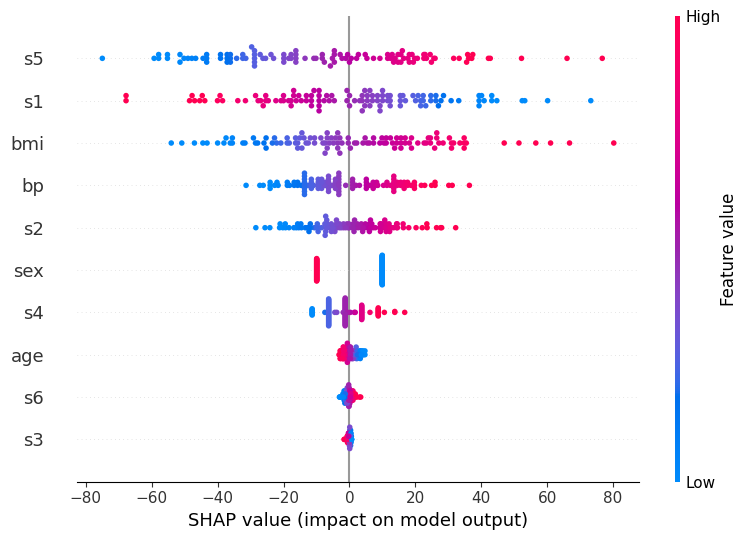

In [29]:
# Create an explainer object for the linear regression model
explainer = shap.Explainer(model_lr, X_train)

# Calculate the Shapley values for the test data
shap_values = explainer.shap_values(X_test)

# Plot the Shapley values
shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)

# Save the figure
plt.tight_layout()
plt.savefig('./latex/pics/shap_summary_plot.pdf', format='pdf')
plt.show()